# <center> Assignment 01: Basic to Complex Image classification <br> <br> <small>14 december 2023</small> </center>

The goal of this assignment is :

    - Classify digits and dog breed from two kaggle datasets.
    - Try to implement a linear and a non-linear model.
    - Compare the accuracies between models in each task.


## Import libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Lambda, Dropout, Input
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Digit regconizer

**Task:** Classify grey-scale hand-written digits from 0 to 9. The images are 28 x 28 pixels. The training dataset is in csv format, has 42000 records with 784 features from pixel0 to pixel783.

The strategy is to implement the linear model of K-Nearest Neighbors while the non-linear model is a CNN layers.

## Data import

In [2]:
# Load both train and test sets
train_master = pd.read_csv("../Assignment 1/digit-recognizer/train.csv")
test_master = pd.read_csv("../Assignment 1/digit-recognizer/test.csv")

train = train_master.copy().drop("label", axis=1)
label = train_master.label
test = test_master.copy()

In [3]:
# Check out the shape
print(train.shape)
print(label.shape)
print(test.shape)

(42000, 784)
(42000,)
(28000, 784)


In [4]:
# Inspect a few rows
train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Inspect test set to be predicted later
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(33600, 784)
(8400, 784)


## Traditional Machine learning

In [7]:
# K as 1 is enough
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [54]:
# Save model
joblib.dump(knn, "../Assignment 1/saved_models/digit_knn.joblib")

['../Assignment 1/saved_models/digit_knn.joblib']

In [9]:
# Test the prediction
y_pred = knn.predict(X_test.to_numpy())
y_pred

array([8, 1, 9, ..., 3, 0, 9])

### Evaluation

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       816
           1       0.97      1.00      0.98       909
           2       0.98      0.95      0.97       846
           3       0.97      0.96      0.96       937
           4       0.98      0.97      0.97       839
           5       0.96      0.96      0.96       702
           6       0.98      0.99      0.98       785
           7       0.96      0.97      0.96       893
           8       0.98      0.94      0.96       835
           9       0.94      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



> Comment: The KNN model performed quite well with an accuracy of 97%. This shalls be the baseline to compare the CNN model with.

### Test model

In [11]:
test_predict = knn.predict(test.to_numpy())

The digit is 4


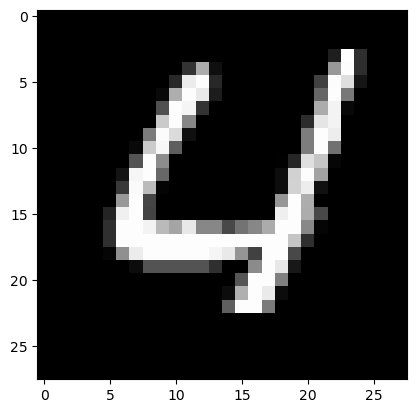

In [12]:
plt.imshow(test.iloc[1200].values.reshape(28, 28), cmap="gray")
print(f'The digit is {test_predict[1200]}')

The digit is 1


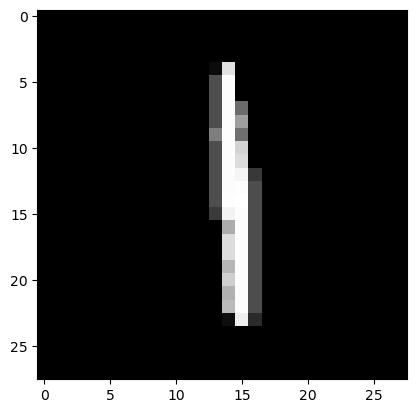

In [13]:
plt.imshow(test.iloc[5000].values.reshape(28, 28), cmap="gray")
print(f'The digit is {test_predict[5000]}')

> We can clearly see the linear model is able to detect digits quite well when we try a couple of examples.

## CNN

### Processing data

In building the CNN, it is a good idea to normalize the data and convert the label with one hot encoder.

In [14]:
X_train_norm = X_train / 255
X_test_norm = X_test / 255

In [15]:
n_classes = 10

Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

### Define Model

In [16]:
model = Sequential()

# One input layer, One calculation layer and one output layer
model.add(Dense(100, input_shape=(784,), activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

2023-12-16 13:48:44.134891: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-16 13:48:44.134926: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-16 13:48:44.134934: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-16 13:48:44.134962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-16 13:48:44.134977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 10)                2010      
                                                                 
Total params: 100710 (393.40 KB)
Trainable params: 100710 (393.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train model

In [17]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(X_train_norm, Y_train, batch_size=64, epochs=20, validation_data=(X_test_norm, Y_test))

Epoch 1/20


2023-12-16 13:48:45.092270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


525/525 [==============================] - 26s 47ms/step - loss: 0.4295 - accuracy: 0.8758 - val_loss: 0.3895 - val_accuracy: 0.8952
Epoch 2/20
525/525 [==============================] - 24s 46ms/step - loss: 0.4266 - accuracy: 0.8883 - val_loss: 0.5830 - val_accuracy: 0.8644
Epoch 3/20
525/525 [==============================] - 24s 45ms/step - loss: 0.9661 - accuracy: 0.8499 - val_loss: 1.3019 - val_accuracy: 0.8292
Epoch 4/20
525/525 [==============================] - 23s 45ms/step - loss: 1.7775 - accuracy: 0.8323 - val_loss: 2.2338 - val_accuracy: 0.8243
Epoch 5/20
525/525 [==============================] - 25s 48ms/step - loss: 2.4887 - accuracy: 0.8317 - val_loss: 3.9317 - val_accuracy: 0.8192
Epoch 6/20
525/525 [==============================] - 27s 51ms/step - loss: 4.3063 - accuracy: 0.8148 - val_loss: 5.0361 - val_accuracy: 0.7883
Epoch 7/20
525/525 [==============================] - 25s 47ms/step - loss: 5.1895 - accuracy: 0.8169 - val_loss: 8.1124 - val_accuracy: 0.7658
Epo

In [18]:
# Save model
model.save("../Assignment 1/saved_models/digit_cnn")

INFO:tensorflow:Assets written to: ../Assignment 1/saved_models/digit_cnn/assets


INFO:tensorflow:Assets written to: ../Assignment 1/saved_models/digit_cnn/assets


> Comment:
> So I tried to build a very simple CNN with 3 layers, an input then a calculation and finally an output layer with the first two have "relu" activation while the last has the "softmax".
> After fitting the model, the accuracy of the CNN is closed to the accuracy of the KNN, around 97% depending on the epochs.
> What I can say is: the digits classification task is rather simple and two models performed nearly similar to each others. However, in the next task with identify the dog breed from the image with larger amount of pixels. We will see how the CNN is better.

### Test model

In [19]:
y_pred_cnn = model.predict(test)

875/875 [==============================] - 1s 1ms/step


The digit is 6


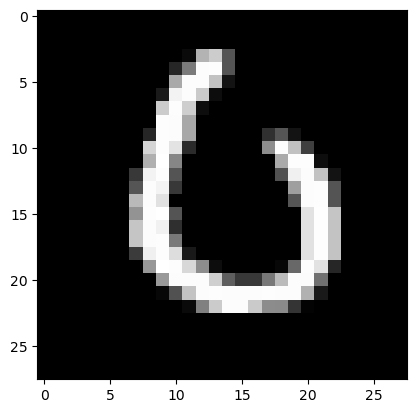

In [20]:
# Test the CNN model
plt.imshow(test.iloc[1900].values.reshape(28, 28), cmap="gray")
print(f'The digit is {np.argmax(y_pred_cnn[1900])}')

The digit is 3


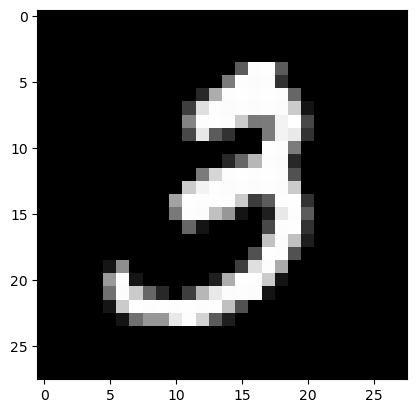

In [21]:
plt.imshow(test.iloc[6900].values.reshape(28, 28), cmap="gray")
print(f'The digit is {np.argmax(y_pred_cnn[6900])}')

# Dog breed

**Task:** Classify different dog breeds from images. The images are in different pixels. The training dataset is a number of dog images with a csv file labelling which breed, there are 10222 images for training.

The same strategy is implemented with one linear model of K-Nearest Neighbors while the non-linear model is a CNN layers.

In [22]:
# Setting some variables
train_path = "../Assignment 1/dog-breed-identification/train/"
labels_path = "../Assignment 1/dog-breed-identification/labels.csv"
img_size = [64, 64, 3]

In [23]:
# Print the number of images in folders
!echo "The number of images in the train folder is: $(ls dog-breed-identification/train/*.jpg | wc -l)"
!echo "The number of images in the test folder is: $(ls dog-breed-identification/test/*.jpg | wc -l)"

The number of images in the train folder is:    10222
The number of images in the test folder is:    10357


## Data import

In [24]:
# Load the labels file
labels_master = pd.read_csv("../Assignment 1/dog-breed-identification/labels.csv")
labels = labels_master.copy()

In [25]:
len(labels)

10222

In [26]:
# Inspect
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [27]:
# Adding the path to the dataframe for later use
labels["path"] = train_path + labels.id + ".jpg"
labels.drop("id", axis=1, inplace=True)
labels.head()

,breed,path
0,boston_bull,../Assignment 1/dog-breed-identification/train...
1,dingo,../Assignment 1/dog-breed-identification/train...
2,pekinese,../Assignment 1/dog-breed-identification/train...
3,bluetick,../Assignment 1/dog-breed-identification/train...
4,golden_retriever,../Assignment 1/dog-breed-identification/train...


In [28]:
def create_dataframe(data: pd.DataFrame, img_size: list[int]):
    """ Return a dataframe of pixels of images

    Argument:
    data: Dataframe with image paths and labels
    img_size: pixel sizes
    """
    all_images = []

    # Transform each image to pixels array and add to one big array
    for idx, row in tqdm(data.iterrows(), total=data.shape[0], desc="Creating dataframe"):
        img = load_img(row['path'], target_size=img_size)
        array_img = img_to_array(img, dtype=np.uint8)
        array_img_t = array_img.flatten()
        all_images.append(array_img_t)

    # Create a dataframe from pixels array
    column_names = [f'pixel{num}' for num in range(len(all_images[0]))]
    df = pd.DataFrame(all_images, columns=column_names)

    return df

In [29]:
X = create_dataframe(labels, img_size)
#len(X)
#X.head()

Creating dataframe: 100%|██████████| 10222/10222 [00:14<00:00, 685.28it/s]


In [30]:
y = labels.breed
y.head()

0         boston_bull
1               dingo
2            pekinese
3            bluetick
4    golden_retriever
Name: breed, dtype: object

In [31]:
# Check how many type of breeds
y.nunique()

120

In [32]:
# Process the labels for CNN also
le = LabelBinarizer()
y_ohe = le.fit_transform(y)

## Splitting data

In [33]:
X_train_dog, X_test_dog, y_train_dog, y_test_dog = train_test_split(X, y_ohe, test_size=0.2, random_state=42)
print(X_train_dog.shape)
print(X_test_dog.shape)

(8177, 12288)
(2045, 12288)


## Traditional machine learning

In [34]:
# Initially testing if KNN is slow in training
X_train_sample = X_train_dog[:1000]
y_train_sample = y_train_dog[:1000]

In [35]:
knn_2 = KNeighborsClassifier(n_neighbors=1)
#knn_2.fit(X_train_sample, y_train_sample)
knn_2.fit(X_train_dog, y_train_dog)

KNeighborsClassifier(n_neighbors=1)

In [55]:
# Save model
joblib.dump(knn_2, "../Assignment 1/saved_models/dog_knn.joblib")

['../Assignment 1/saved_models/dog_knn.joblib']

In [37]:
y_pred_dog = knn_2.predict(X_test_dog.to_numpy())

In [38]:
accuracy_score(y_test_dog, y_pred_dog)

0.033251833740831294

> Comment: As we can clearly see, for the digits task, the KNN performed well but with a much more complex task like dog breed identification, it does not perform well at all. Our baseline for this task at the moment is 0.033 for the accuracy.

## CNN

In [39]:
def process_images(data: pd.DataFrame, img_size: list[int] = [224, 224]):
    """ Return the pixels array for CNN

    Argument:
    data: Dataframe with image paths and labels
    img_size: pixel sizes
    """

    # Create a list to hold pixels
    img_arrays = []

    # Transform each image into pixels array
    for _, row in tqdm(data.iterrows(), total=data.shape[0], desc="Creating array"):
        img = load_img(row.path, target_size=img_size)
        img_array = img_to_array(img, dtype=np.uint8)
        img_arrays.append(img_array)

    # Convert into a numpy array for the CNN
    one_img_arr = np.array(img_arrays)
    return one_img_arr

In [40]:
X_cnn = process_images(labels)

Creating array: 100%|██████████| 10222/10222 [00:14<00:00, 682.52it/s]


In [41]:
X_cnn.shape

(10222, 224, 224, 3)

> Comment: With KNN, the pixels size is very important because the higher the size, the longer it takes to convert into array and longer training time. With CNN, it is easier as it can deal with larger pixels size.

### Build from scratch

In [42]:
X_train_dog_cnn, X_test_dog_cnn, y_train_dog_cnn, y_test_dog_cnn = train_test_split(X_cnn, y_ohe, test_size=.2, random_state=42)

In [43]:
# Normalize data
X_train_dog_cnn = X_train_dog_cnn / 255
X_test_dog_cnn = X_test_dog_cnn / 255

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3), padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_2.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_2.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_2.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_2.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_2.add(Flatten())
model_2.add(Dense(512, activation="relu"))
model_2.add(Dense(y.nunique(), activation="softmax"))
model_2.summary()

model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model_2.fit(X_train_dog_cnn, y_train_dog_cnn, batch_size=64, epochs=10, validation_data=(X_test_dog_cnn, y_test_dog_cnn))

> Comment: Build my own CNN model took a long time, each epoch took at least 300 seconds to train. So I tried the transfer learning approach.

### Transfer learning

In [44]:
# Credit to the HÜSEYIN CENİK team on kaggle for the following code
def get_features(model_name, model_preprocessor, input_size, data):
    """ Return extracted features from the pre-defined extractor

    Argument:
    model_name: The pre-defined model
    model_preprocessor: The model preprocessing function
    input_size: array size
    data: input array
    """

    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    maxPool = MaxPooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=maxPool)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

#### InceptionV3

In [45]:
features = get_features(InceptionV3, inception_preprocess, [224, 224, 3], X_cnn)

320/320 [==============================] - 73s 162ms/step
Feature maps shape: (10222, 2, 2, 2048)


In [46]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(features, y_ohe, test_size=.2, random_state=42)

In [47]:
model_3 = Sequential()

# Input layer
model_3.add(Input(X_train_tf.shape[1:]))
# Flatten the array into 1D
model_3.add(Flatten())
# Add dropout to combat overfitting
model_3.add(Dropout(0.2))
# One calculation layer
model_3.add(Dense(512, activation="relu"))
# Output layer
model_3.add(Dense(y.nunique(), activation="softmax"))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dense_4 (Dense)             (None, 120)               61560     
                                                                 
Total params: 4256376 (16.24 MB)
Trainable params: 4256376 (16.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
model_3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [49]:
# Testing Early stopping technique
es = EarlyStopping(monitor='val_accuracy', min_delta=1, verbose=1, patience=5, restore_best_weights=True)

In [50]:
# Trained the model
model_3.fit(X_train_tf, y_train_tf, batch_size=64, epochs=20, validation_data=(X_test_tf, y_test_tf))#, callbacks=[es])

Epoch 1/20
128/128 [==============================] - 9s 61ms/step - loss: 8.8875 - accuracy: 0.4718 - val_loss: 5.6514 - val_accuracy: 0.5927
Epoch 2/20
128/128 [==============================] - 7s 52ms/step - loss: 4.5907 - accuracy: 0.6630 - val_loss: 4.7999 - val_accuracy: 0.6597
Epoch 3/20
128/128 [==============================] - 7s 52ms/step - loss: 4.2923 - accuracy: 0.7006 - val_loss: 6.3733 - val_accuracy: 0.6411
Epoch 4/20
128/128 [==============================] - 7s 52ms/step - loss: 3.9476 - accuracy: 0.7404 - val_loss: 5.6360 - val_accuracy: 0.6978
Epoch 5/20
128/128 [==============================] - 6s 51ms/step - loss: 3.4278 - accuracy: 0.7689 - val_loss: 5.5923 - val_accuracy: 0.6944
Epoch 6/20
128/128 [==============================] - 7s 53ms/step - loss: 2.8044 - accuracy: 0.7964 - val_loss: 6.7579 - val_accuracy: 0.6895
Epoch 7/20
128/128 [==============================] - 7s 51ms/step - loss: 3.1512 - accuracy: 0.8018 - val_loss: 6.5825 - val_accuracy: 0.6998

In [51]:
# Save model
model_3.save("../Assignment 1/saved_models/dog_cnn")

INFO:tensorflow:Assets written to: ../Assignment 1/saved_models/dog_cnn/assets


INFO:tensorflow:Assets written to: ../Assignment 1/saved_models/dog_cnn/assets


> Comment: as we can see the accuracy of the new model performs really well. I got at least 74% accuracy, which is a huge improvement to the previous baseline. We can safely say I should use this model.

### Test model

In [52]:
# Map each breed with an index
breeds = sorted(labels["breed"].unique().tolist())
breeds_dict = dict(zip(breeds, range(len(breeds))))
#print(class_to_num)

Predicting images:   0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step
Feature maps shape: (1, 2, 2, 2048)
1/1 [==============================] - 0s 290ms/step


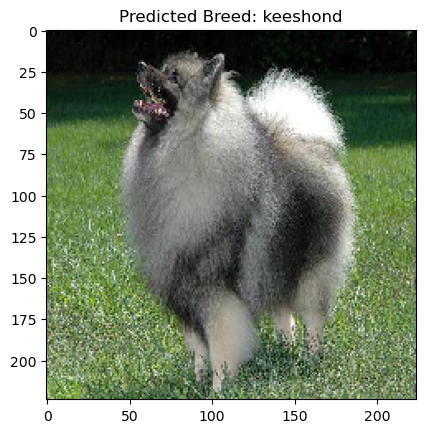

Predicting images:  50%|█████     | 1/2 [00:09<00:09,  9.92s/it]

1/1 [==============================] - 7s 7s/step
Feature maps shape: (1, 2, 2, 2048)
1/1 [==============================] - 0s 20ms/step


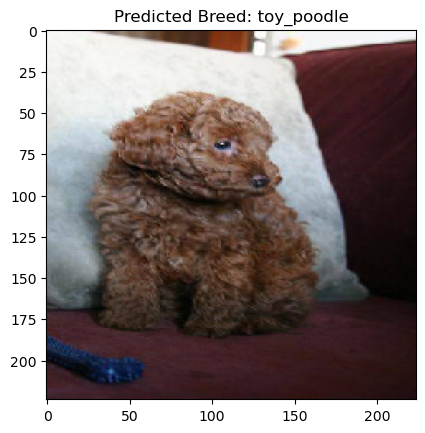

Predicting images: 100%|██████████| 2/2 [00:19<00:00,  9.62s/it]


In [53]:
def load_and_preprocess_image(image_path, target_size=[224, 224]):
    """ Process one image to be extracted

    Argument:
    image_path: Path to the image
    """

    # Load and transform images
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img, dtype=np.uint8)
    img_reshaped = img_array.reshape((1, 224, 224, 3))
    return img_reshaped

test_path = "../Assignment 1/dog-breed-identification/test/"

for filename in tqdm(os.listdir(test_path)[50:52], desc='Predicting images'): # Change which file to be predicted here
    # Get the whole path
    file_path = os.path.join(test_path, filename)

    # Transform image
    img_pred = load_and_preprocess_image(file_path)

    # Extract features
    test_feature = get_features(InceptionV3, inception_preprocess, [224, 224, 3], img_pred)

    # Get the predicted label
    breed_index = model_3.predict(test_feature).argmax(axis=-1)
    breed_label = [
        label for label, index in breeds_dict.items() if index == breed_index
    ][0]

    # Display the predicted label
    display_img_array = np.squeeze(img_pred, axis=0)
    plt.imshow(display_img_array)
    plt.title(f"Predicted Breed: {breed_label}")
    plt.show()